# Discrete latent variable models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

from src.discrete_latent_variables import GaussianMixtureModel, GaussianHiddenMarkovModel
from src.components import Bernoulli, Categorical, LinearRegression, LogisticRegression, KMeans, logsumexp

np.random.seed(1)

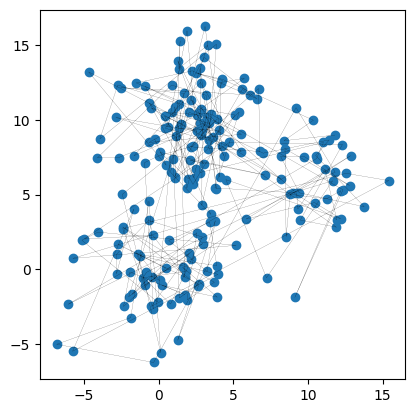

In [2]:
# create sequential data set by hierarchical sampling from a Markov model
gt_hmm = GaussianHiddenMarkovModel(
    pi=np.ones(3) / 3,
    A=np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]),
    mu=np.array([[0, 0], [2, 10], [10, 5]]),
    Sigma=np.asarray([np.eye(2) * 8 for _ in range(3)]))
X = gt_hmm.draw(200)

plt.scatter(X[:, 0], X[:, 1])
plt.plot(X[:, 0], X[:, 1], "k", linewidth=0.1)
plt.gca().set_aspect("equal")
plt.show()

## Mixture of Gaussians

See Bishop chapter 9.2.

* assumes i.i.d. observations $\mathbf{x}_n$

* latent variables $\mathbf{z}_n$ are categorical

* emission distributions are Gaussian

$$p\left( \mathbf{z}_n \right) = \text{Cat}\left(\mathbf{\pi}\right)$$

$$p\left( \mathbf{x}_n | \mathbf{z}_n \right) = \mathcal{N}\left(\mathbf{x}_n | \mathbf{\mu}_{\mathbf{z}_n}, \mathbf{\Sigma}_{\mathbf{z}_n}\right)$$

Log likelihood with K-means parameters: -1130.9019323205584
Log likelihood after fitting mixture model: -1126.9818291494412


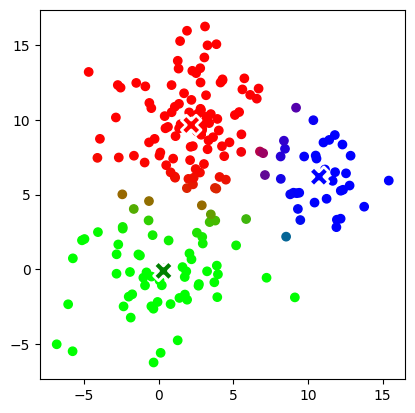

In [3]:
K = 3
# initialize Gaussian mixture model with K-means
kmeans = KMeans(K)
kmeans.fit(X)
mu = kmeans.mu
c_ind = kmeans.transform(X)
Sigma = np.array([np.cov(X[c_ind == k], rowvar=False) for k in range(K)])
pi = np.array([sum(c_ind == k) / len(c_ind) for k in range(K)])
gmm = GaussianMixtureModel(pi=pi,
                           mu=mu,
                           Sigma=Sigma)
print("Log likelihood with K-means parameters: {}".format(gmm.log_likelihood(X)))
gmm.mle(X)
print("Log likelihood after fitting mixture model: {}".format(gmm.log_likelihood(X)))
posterior_mean = gmm.e_step(X)[0]

mu_x = [c.mu[0] for c in gmm.emission_models]
mu_y = [c.mu[1] for c in gmm.emission_models]
plt.scatter(X[:, 0], X[:, 1], c=posterior_mean)
plt.scatter(mu_x, mu_y, s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.gca().set_aspect("equal")
plt.show()

## Gaussian hidden Markov model

See Bishop chapter 13.2. 

* extension of the Gaussian mixture model to sequential (non-i.i.d.) data 

* assumes that the latent variables form a (first order) Markov chain

* emission distributions are Gaussian

$$p\left( \mathbf{z}_1 \right) = \text{Cat}\left(\mathbf{\pi}\right)$$

$$p\left( \mathbf{z}_n | \mathbf{z}_{n-1} \right) = \text{Cat}\left(\mathbf{A} \mathbf{z}_{n-1}\right)$$

$$p\left( \mathbf{x}_n | \mathbf{z}_n \right) = \mathcal{N}\left(\mathbf{x}_n | \mathbf{\mu}_{\mathbf{z}_n}, \mathbf{\Sigma}_{\mathbf{z}_n}\right)$$

Log likelihood of fitted Gaussian mixture model: -1126.9818291494412
Log likelihood of fitted Gaussian hidden Markov model: -1022.168016509047


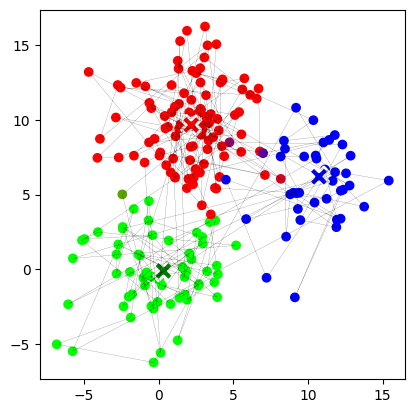

In [4]:
# initialize hidden Markov model with i.i.d. mixture model parameters
pi = gmm.pi
mu = np.stack([c.mu for c in gmm.emission_models], axis=0)
Sigma = np.stack([c.Sigma for c in gmm.emission_models], axis=0)
gaussian_hmm = GaussianHiddenMarkovModel(
    pi=pi,
    A=np.ones((K, K)) / K,
    mu=mu,
    Sigma=Sigma)

print("Log likelihood of fitted Gaussian mixture model: {}".format(gmm.log_likelihood(X)))
gaussian_hmm.mle(X)
print("Log likelihood of fitted Gaussian hidden Markov model: {}".format(gaussian_hmm.log_likelihood(X)))
posterior_mean = gaussian_hmm.e_step(X)[0]

mu_x = [c.mu[0] for c in gmm.emission_models]
mu_y = [c.mu[1] for c in gmm.emission_models]

plt.scatter(X[:, 0], X[:, 1], c=np.clip(posterior_mean, 0, 1))
plt.scatter(mu_x, mu_y, s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.plot(X[:, 0], X[:, 1], "k", linewidth=0.1)
plt.gca().set_aspect("equal")
plt.show()

## Extensions

Discrete latent variable models can be extended to higher-order Markov chains, non-linear transition models, and non-linear and/or non-Gaussian emission models. 

Among many other extensions, Bishop discusses mixtures of Bernoulli distributions and categorical hidden Markov models, which we can obtain by making very few modifications: As shown in the `m_step` methods of the `GaussianMixtureModel` and `GaussianHiddenMarkovModel` classes, the maximization step is independent for each emission model/component. It simply corresponds to a reweighted maximum likelihood estimation of the emission model parameters (weighted by the posterior mean of the latent variables).

Note that the emission model could also be parameterized by a deep neural network.

### Mixtures of Bernoulli distributions

See Bishop chapter 9.3.3.

In [5]:
# get dataset
x, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False, parser="liac-arff")
X = []
for i in [2, 3, 4]:
    X.append(x[np.random.choice(np.where(y == str(i))[0], 600)])
X = np.concatenate(X, axis=0)
X = (X > 127).astype(float)

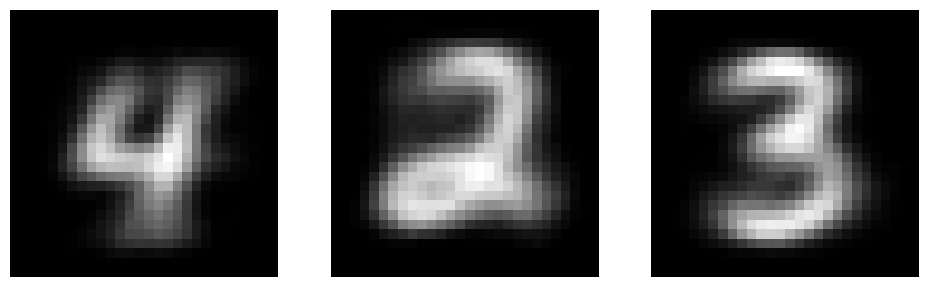

In [6]:
# override emission model to create Bernoulli mixture
class BernoulliMixtureModel(GaussianMixtureModel):
    def __init__(self, pi, mu):
        self.K = pi.shape[0]
        self.pi = pi
        self.emission_models = [Bernoulli(m) for m in mu]

K = 3
bmm = BernoulliMixtureModel(pi=np.ones(K) / K,
                            mu=np.random.uniform(0.25, 0.75, size=(K, X.shape[1])))
bmm.mle(X, iter_max=10)

plt.figure(figsize=(20, 5))
for i, c in enumerate(bmm.emission_models):
    plt.subplot(1, 5, i + 1)
    plt.imshow(c.mu.reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()

### Categorical hidden Markov model

See Bishop chapter 13.2.1.

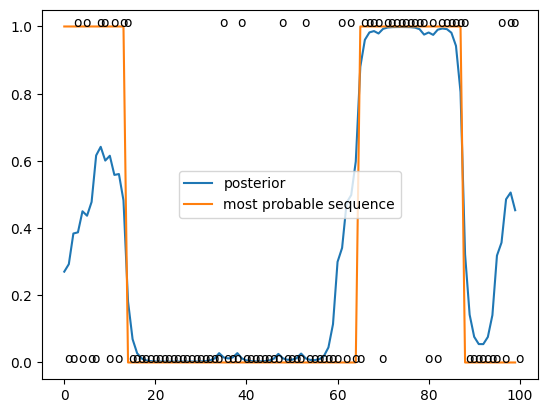

In [7]:
# override emission model to create Categorical hidden Markov model
class CategoricalHiddenMarkovModel(GaussianHiddenMarkovModel):
    def __init__(self, pi, A, mu):
        self.K = pi.shape[0]
        self.pi = pi
        self.A = A
        self.emission_models = [Categorical(m) for m in mu]
        
categorical_hmm = CategoricalHiddenMarkovModel(
    pi=np.ones(2) / 2,
    A=np.array([[0.95, 0.05], [0.05, 0.95]]),
    mu=np.array([[0.8, 0.2], [0.3, 0.7]]))

X = categorical_hmm.draw(100)
posterior_mean = categorical_hmm.e_step(X)[0]
# use Viterbi algorithm to find most probable sequence
most_probable = categorical_hmm.viterbi(X)

plt.plot(posterior_mean[:, 1], label="posterior")
plt.plot(most_probable, label="most probable sequence")
for i in range(0, len(X)):
    plt.annotate("o", (i, X[i]))
plt.legend()
plt.show()

### Conditional Mixture Models

Conditional mixture models (Bishop chapter 14.5) have exactly the same structure as unconditional mixture models. To illustrate this, we still use the same class, and again just override the emission models.

#### Mixture of linear regression models

Bishop chapter 14.5.1.

In [8]:
# create data set
x1 = np.random.normal(size=(50, 2)) @ np.diag([1.7, 0.05])
x1 += np.array([5, 1])
x2 = np.random.normal(size=(25, 2)) @ np.diag([0.3, 0.05])
x2 += np.array([0, 0])
x3 = np.random.normal(size=(25, 2)) @ np.diag([0.3, 0.05])
x3 += np.array([10, 0.1])
data = np.vstack((x1, x2, x3))
X = data[:, 0][:, None]
t = data[:, 1]

def mixture_model_log_pdf(mixture_model, data):
    # same as .log_likelihood() but no sum over n
    return logsumexp(
            [
                np.log(p) + c.log_pdf(data)
                for p, c in zip(mixture_model.pi, mixture_model.emission_models)
            ],
            axis=0,
        )

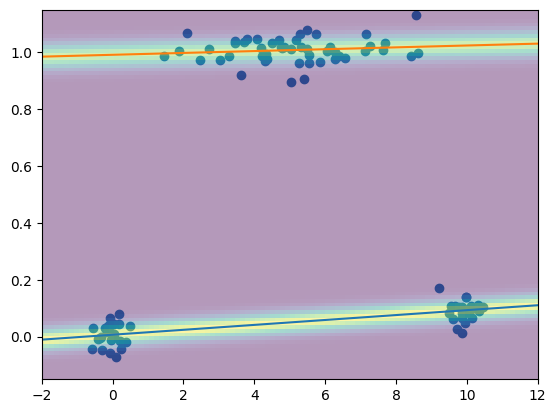

In [9]:
# override emission model to create mixture of linear regression models
class MixtureOfLinearRegression(GaussianMixtureModel):
    def __init__(self, pi, w, beta):
        self.K = pi.shape[0]
        self.pi = pi
        self.emission_models = [LinearRegression(wk, beta) for wk in w]

K = 2
model = MixtureOfLinearRegression(
    pi=np.ones(K) / K, 
    w=np.random.randn(K, 2) * 0.1, 
    beta=1.0
)

X_intercept = np.concatenate([X, np.ones([X.shape[0], 1])], axis=1)
# convergence depends heavily on initialization, 
# execute a few times and compare
model.mle((X_intercept, t), iter_max=200)

xmin, xmax = -2, 12
ymin, ymax = -0.15, 1.15
X_grid, t_grid = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
X_grid, t_grid = X_grid.ravel(), t_grid.ravel()
X_grid_intercept = np.stack([X_grid, np.ones_like(X_grid)], axis=1)

pdf = np.exp(mixture_model_log_pdf(model, (X_grid_intercept, t_grid)))
for c in model.emission_models:
    y = c.predict(X_grid_intercept)
    plt.plot(X_grid, y)
plt.scatter(X[:, 0], t)
plt.pcolormesh(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100), pdf.reshape(100, 100), alpha=0.4)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

#### Mixture of logistic regression models

Bishop chapter 14.5.2.

In [10]:
# create dataset
x1 = np.random.randn(200, 2) * 1.5 + np.array([5.5, 10])
x2 = np.random.randn(200, 2) * 1.5 + np.array([4.5, 0])
x3 = np.random.randn(200, 2) * 1.5 + np.array([0, 4.5])
x4 = np.random.randn(200, 2) * 1.5 + np.array([10, 5.5])
X = np.concatenate([x1, x2, x3, x4], axis=0)
t = np.concatenate([np.ones([400]), np.zeros([400])])

Log likelihood after init: -368.52770183884604
Log likelihood after MLE fit:  -346.3573769569963


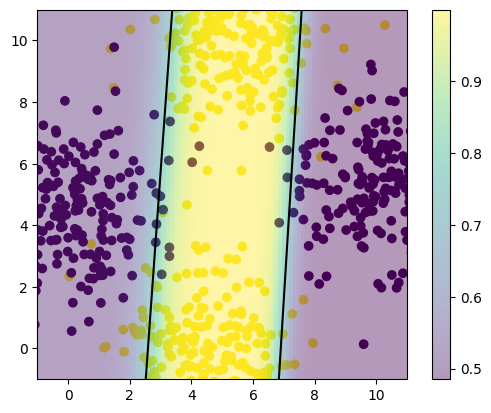

In [11]:
# override emission model to create mixture of logistic regression models
class MixtureOfLogisticRegression(GaussianMixtureModel):
    def __init__(self, pi, w):
        self.K = pi.shape[0]
        self.pi = pi
        self.emission_models = [LogisticRegression(wk) for wk in w]


# init is key for convergence: split data along axis and 
# fit separate logistic regression models first
X_intercept = np.concatenate([X, np.ones([X.shape[0], 1])], axis=1)
split_val = np.median(X[:, 0])
X_left = X_intercept[X[:, 0] < split_val]
t_left = t[X[:, 0] < split_val]
X_right = X_intercept[X[:, 0] >= split_val]
t_right = t[X[:, 0] >= split_val]
model_left = LogisticRegression(w=np.zeros(X_intercept.shape[1]))
model_left.mle((X_left, t_left), iter_max=10000)
model_right = LogisticRegression(w=np.zeros(X_intercept.shape[1]))
model_right.mle((X_right, t_right), iter_max=10000)

# initialize mixture model with weights from the separate models
K = 2
model = MixtureOfLogisticRegression(
    pi=np.ones(K) / K,
    w=np.stack([model_left.w, model_right.w], axis=0)
)

xmin, xmax = -1, 11
ymin, ymax = -1, 11
X1_grid, X2_grid = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
X_grid = np.array([X1_grid, X2_grid]).reshape(2, -1).T
X_grid_intercept = np.concatenate([X_grid, np.ones([X_grid.shape[0], 1])], axis=1)
t_grid = np.ones(X_grid.shape[0])
x1_test, x2_test = np.meshgrid(np.linspace(-1, 11, 100), np.linspace(-1, 11, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

print("Log likelihood after init: {}".format(model.log_likelihood((X_intercept, t))))
model.mle((X_intercept, t), iter_max=10000)
print("Log likelihood after MLE fit:  {}".format(model.log_likelihood((X_intercept, t))))

pdf = np.exp(mixture_model_log_pdf(model, (X_grid_intercept, t_grid)))

# plot the decision boundaries
for c in model.emission_models:
    y = -c.w[0]/c.w[1] * X1_grid[0] - c.w[2]/c.w[1]
    plt.plot(X1_grid[0], y, c='k')

plt.scatter(X[:, 0], X[:, 1], c=t)
plt.pcolormesh(X1_grid, X2_grid, pdf.reshape(100, 100), alpha=0.4)
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.gca().set_aspect('equal')
plt.show()